**Pet Image Classifier**

In [1]:
%matplotlib inline

In [2]:
!pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.5 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 6.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [3]:
from fastai.vision.all import *
from nbdev.showdoc import *

set_seed(2)

In [4]:
bs = 16

**Understanding the data**

In [5]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
    Download `url` using `FastDownload.get`



In [6]:
path = untar_data(URLs.PETS); path

Path('/root/.fastai/data/oxford-iiit-pet')

In [7]:
Path.BASE_PATH = path # display all paths relative to dataset root
path.ls()

(#2) [Path('images'),Path('annotations')]

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

In [9]:
fnames = get_image_files(path_img)
fnames

(#7390) [Path('images/miniature_pinscher_134.jpg'),Path('images/yorkshire_terrier_38.jpg'),Path('images/beagle_109.jpg'),Path('images/scottish_terrier_126.jpg'),Path('images/Bombay_79.jpg'),Path('images/Sphynx_93.jpg'),Path('images/Ragdoll_201.jpg'),Path('images/Egyptian_Mau_20.jpg'),Path('images/german_shorthaired_48.jpg'),Path('images/saint_bernard_52.jpg')...]

In [10]:
dls = ImageDataLoaders.from_name_re(
    path, fnames, pat=r'(.+)_\d+.jpg$', item_tfms=Resize(460), bs=bs,
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

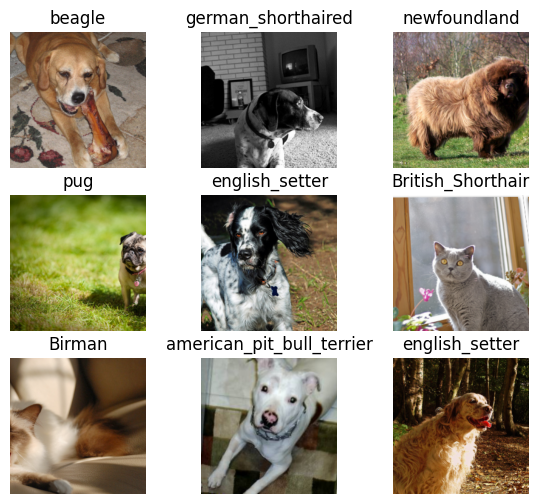

In [11]:
dls.show_batch(max_n=9, figsize=(7,6))

In [12]:
print(dls.vocab)
len(dls.vocab),dls.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

**Training: resnet34**

In [13]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 55.0MB/s]


In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.fit_one_cycle(4)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,0.919499,0.344950,0.120433,01:19
1,0.670414,0.225708,0.073748,01:24
2,0.446095,0.217158,0.071719,01:17
3,0.358558,0.187414,0.065629,01:16


In [16]:
learn.save('stage-1')

Path('models/stage-1.pth')

Results

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

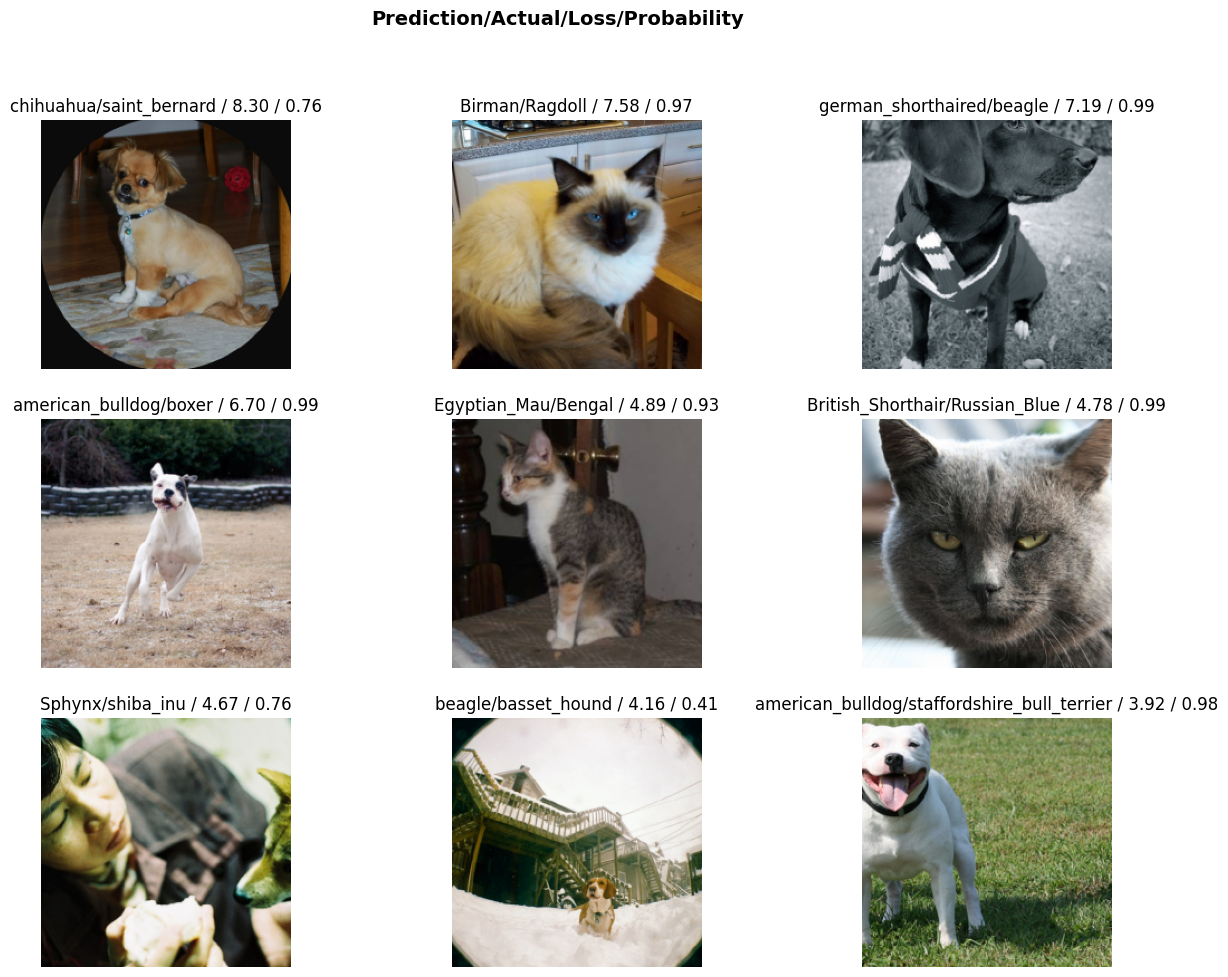

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
doc(interp.plot_top_losses)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


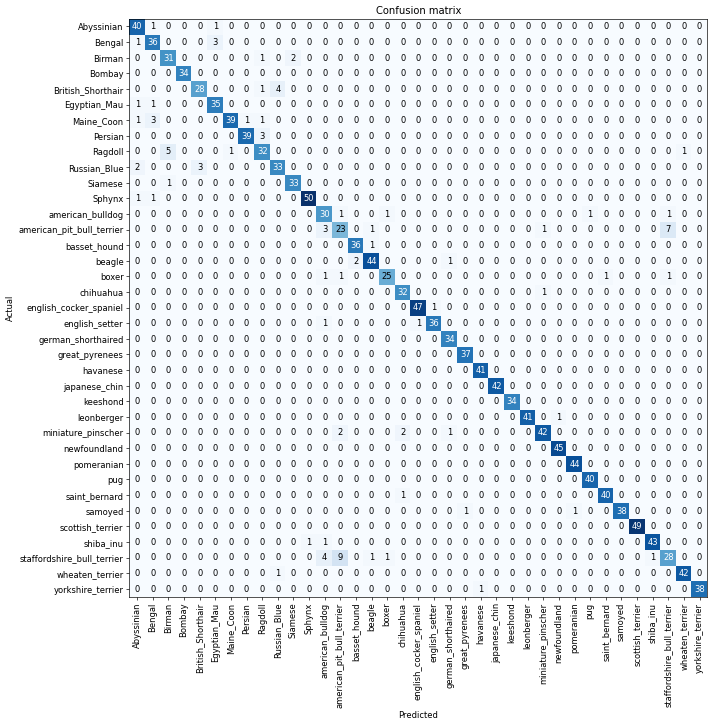

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Ragdoll', 'Birman', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Maine_Coon', 'Bengal', 3),
 ('Persian', 'Ragdoll', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('Birman', 'Siamese', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('beagle', 'basset_hound', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'chihuahua', 2)]

**Unfreezing, fine-tuning, and learning rates**

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.539119,1.547426,0.460081,01:22


In [24]:
learn.load('stage-1');

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=3.0199516913853586e-05)

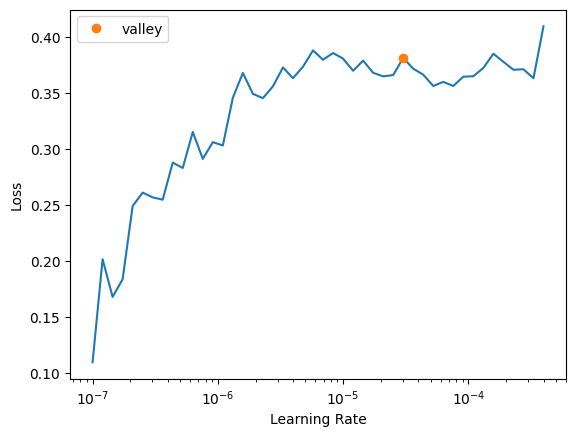

In [25]:
learn.lr_find()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.337598,0.184222,0.061570,01:25
1,0.323603,0.180815,0.064276,01:22


**Training: resnet50**

In [27]:
dls = ImageDataLoaders.from_path_re(path_img, fnames, pat=r'(.+)_\d+.jpg$', item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=bs//2,
                                     batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [28]:
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.8MB/s]


SuggestedLRs(valley=0.0008317637839354575)

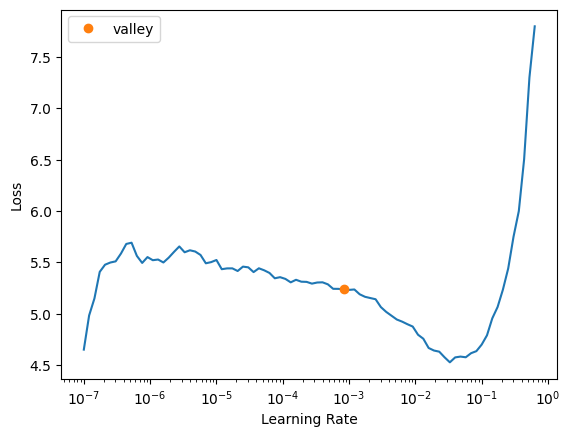

In [29]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.400463,0.466903,0.145467,01:37
1,0.880070,0.293323,0.089310,01:43
2,0.621838,0.221695,0.075101,01:38


epoch,train_loss,valid_loss,error_rate,time
0,1.400463,0.466903,0.145467,01:37
1,0.880070,0.293323,0.089310,01:43
2,0.621838,0.221695,0.075101,01:38
3,0.572818,0.233727,0.067659,01:37
4,0.433883,0.211666,0.069012,01:40
5,0.352073,0.196047,0.060893,01:35
6,0.303594,0.176350,0.052097,01:37
7,0.262752,0.187153,0.058187,01:36


In [31]:
learn.save('stage-1-50')

Path('images/models/stage-1-50.pth')

In [32]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.296766,0.174708,0.056834,01:51
1,0.283471,0.167207,0.052097,01:52
2,0.235854,0.178839,0.054804,01:50


In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [35]:
interp.most_confused(min_val=2)

[('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier',
  '/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier',
  8),
 ('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau',
  '/root/.fastai/data/oxford-iiit-pet/images/Bengal',
  6),
 ('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll',
  '/root/.fastai/data/oxford-iiit-pet/images/Birman',
  6),
 ('/root/.fastai/data/oxford-iiit-pet/images/Bengal',
  '/root/.fastai/data/oxford-iiit-pet/images/Abyssinian',
  5),
 ('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair',
  '/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue',
  4),
 ('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue',
  '/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair',
  3),
 ('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier',
  '/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier',
  3),
 ('/root/.fastai/data/oxford-iiit-pet/images/Birman',
  '/root/.fastai/data/oxf

**Other data formats**

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [ ]:
tfms = aug_transforms(do_flip=False)
data = ImageDataLoaders.from_folder(path, batch_tfms=tfms, size=26, bs=bs)

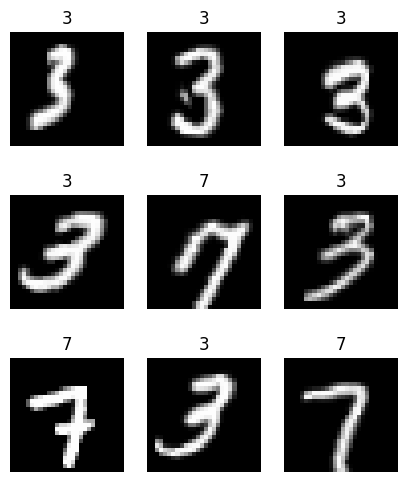

In [38]:
data.show_batch(max_n=9, figsize=(5,6))

In [39]:
learn = vision_learner(data, resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.7MB/s]


epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.112193,0.055573,0.984298,00:37
1,0.093563,0.039291,0.988224,00:38


In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [41]:
data = ImageDataLoaders.from_csv(path, batch_tfms=tfms, size=28)

/usr/local/lib/python3.10/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


[0, 1]

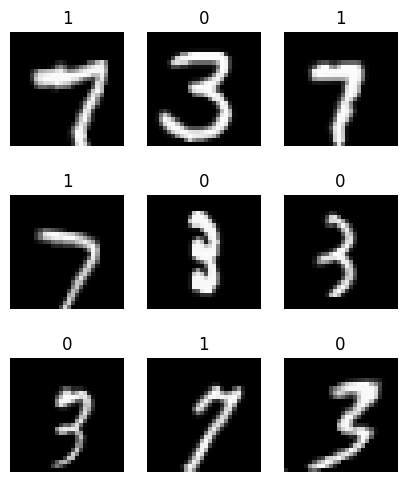

In [42]:
data.show_batch(max_n=9, figsize=(5,6))
data.vocab

In [43]:
data = ImageDataLoaders.from_df(df, path=path, batch_tfms=tfms, size=24)
data.vocab

/usr/local/lib/python3.10/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


[0, 1]

In [44]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[Path('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 Path('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [45]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataLoaders.from_path_re(path, fn_paths, pat=pat, batch_tfms=tfms, size=24)
data.vocab

['3', '7']

In [46]:
data = ImageDataLoaders.from_path_func(path, fn_paths, batch_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.vocab

['3', '7']

In [47]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [48]:
data = ImageDataLoaders.from_lists(path, fn_paths, labels=labels, batch_tfms=tfms, size=24)
data.vocab

['3', '7']

['3', '7']